In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from concurrent.futures import ProcessPoolExecutor, as_completed

#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 50)

# 最大表示行数の指定（ここでは50行を指定）
pd.set_option('display.max_rows', 500)

In [2]:
train_df = pd.read_parquet('../data/feature_engineering_v10_train_df.parquet')
test_df = pd.read_parquet('../data/feature_engineering_v10_test_df.parquet')

train_label = pd.read_csv('../train_label.csv')
test_session = pd.read_csv('../test_session.csv')

train_log = pd.read_csv('../train_log.csv')
test_log = pd.read_csv('../test_log.csv')

In [3]:
train_df

,session_id,yado_no,target,predict_no,seq_no,seen_yad,max_seq_no,diff_seq_no,is_odd,multiple_visits_flag,yad_type,total_room_cnt,wireless_lan_flg,onsen_flg,kd_stn_5min,kd_bch_5min,kd_slp_5min,kd_conv_walk_5min,wid_cd,ken_cd,lrg_cd,sml_cd,popularity,overall_rank,wid_cd_rank,ken_cd_rank,lrg_cd_rank,sml_cd_rank,label_wid_cd,label_ken_cd,label_lrg_cd,label_sml_cd,count_wid_cd,count_ken_cd,count_lrg_cd,count_sml_cd,count_yado_no,fold,TE_wid_cd_mean,TE_wid_cd_var,TE_ken_cd_mean,TE_ken_cd_var,TE_lrg_cd_mean,TE_lrg_cd_var,TE_sml_cd_mean,TE_sml_cd_var,TE_yado_no_mean,TE_yado_no_var
0,000125c737df1802b6e365f93c96d3c8,7531,0,0,-1,0,0,-1,-1,0,0,97.0,1.0,0,-1.0,-1.0,-1.0,1.0,43875109d1dab93592812c50d18270a7,3b09a7ce9934c00fd266f9cf246308d1,c0e203c17b3a418d089e96aac011d1a1,a5a49a911ded94700d282a1d4ff3a373,132.0,1158.5,33.0,10.0,10.0,7.0,5,12,15,19,97420,28008,22512,15711,953,0,0.037534,0.036126,0.042687,0.040867,0.034700,0.033498,0.031581,0.030586,0.028802,0.028005
1,000125c737df1802b6e365f93c96d3c8,441,0,1,-1,0,0,-1,-1,0,0,314.0,1.0,0,-1.0,-1.0,-1.0,1.0,43875109d1dab93592812c50d18270a7,3b09a7ce9934c00fd266f9cf246308d1,c0e203c17b3a418d089e96aac011d1a1,a5a49a911ded94700d282a1d4ff3a373,161.0,714.5,16.0,7.0,7.0,4.0,5,12,15,19,97420,28008,22512,15711,958,0,0.037534,0.036126,0.042687,0.040867,0.034700,0.033498,0.031581,0.030586,0.032295,0.031288
2,000125c737df1802b6e365f93c96d3c8,2480,0,2,-1,0,0,-1,-1,0,0,144.0,1.0,0,1.0,-1.0,-1.0,1.0,43875109d1dab93592812c50d18270a7,3b09a7ce9934c00fd266f9cf246308d1,c0e203c17b3a418d089e96aac011d1a1,a5a49a911ded94700d282a1d4ff3a373,142.0,961.5,23.0,9.0,9.0,6.0,5,12,15,19,97420,28008,22512,15711,941,0,0.037534,0.036126,0.042687,0.040867,0.034700,0.033498,0.031581,0.030586,0.028136,0.027376
3,000125c737df1802b6e365f93c96d3c8,13240,0,3,-1,0,0,-1,-1,0,0,150.0,1.0,1,1.0,-1.0,-1.0,1.0,43875109d1dab93592812c50d18270a7,3b09a7ce9934c00fd266f9cf246308d1,c0e203c17b3a418d089e96aac011d1a1,a5a49a911ded94700d282a1d4ff3a373,123.0,1340.0,38.0,11.0,11.0,8.0,5,12,15,19,97420,28008,22512,15711,558,0,0.037534,0.036126,0.042687,0.040867,0.034700,0.033498,0.031581,0.030586,0.027888,0.027165
4,000125c737df1802b6e365f93c96d3c8,10378,1,4,-1,0,0,-1,-1,0,0,264.0,1.0,1,-1.0,-1.0,-1.0,1.0,43875109d1dab93592812c50d18270a7,3b09a7ce9934c00fd266f9cf246308d1,c0e203c17b3a418d089e96aac011d1a1,a5a49a911ded94700d282a1d4ff3a373,109.0,1679.5,47.0,15.0,15.0,10.0,5,12,15,19,97420,28008,22512,15711,474,0,0.037534,0.036126,0.042687,0.040867,0.034700,0.033498,0.031581,0.030586,0.035129,0.033974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,0,5,-1,0,2,-1,-1,0,1,-1.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,e5680545edc53d20bb05168e67c9f9f0,50.0,4353.0,509.0,63.0,25.0,7.0,4,24,148,227,335580,38742,11787,2856,209,9,0.034683,0.033480,0.040933,0.039258,0.037473,0.036072,0.040404,0.038787,0.016129,0.015955
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,0,6,-1,0,2,-1,-1,0,0,198.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,e5680545edc53d20bb05168e67c9f9f0,138.0,1039.0,136.0,18.0,11.0,5.0,4,24,148,227,335580,38742,11787,2856,338,9,0.034683,0.033480,0.040933,0.039258,0.037473,0.036072,0.040404,0.038787,0.019737,0.019411
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,0,7,-1,0,2,-1,-1,0,0,94.0,1.0,1,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,840f2157ec5bb4f5501a3ace2f4ef8d1,120.0,1408.0,193.0,27.0,15.0,9.0,4,24,148,228,335580,38742,11787,8931,555,9,0.034683,0.033480,0.040933,0.039258,0.037473,0.036072,0.036554,0.035222,0.025794,0.025178
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,0,8,-1,0,2,-1,-1,0,0,310.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013

In [4]:
print(train_df['seen_yad'].value_counts())
print(test_df['seen_yad'].value_counts())

0    2777527
Name: seen_yad, dtype: int64
0    1683604
Name: seen_yad, dtype: int64


### CatBoost Ranker

In [5]:
import numpy as np
import pandas as pd
from sklearn.metrics import label_ranking_average_precision_score
from catboost import CatBoostRanker, Pool

# 特徴量とターゲットの定義
all_features = train_df.columns.to_list()
features= [x for x in all_features if x not in ('session_id', 'fold', 'target', 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd', 'seen_yad', 'TE_wid_cd', 'TE_ken_cd', 'TE_lrg_cd', 'TE_sml_cd', 'TE_yado_no')] # seen_yadも入れる 
cat_cols = ['yado_no']+ ['label_wid_cd', 'label_ken_cd', 'label_lrg_cd', 'label_sml_cd'] 
target = 'target'  # ターゲット変数の列名
query_ids =  'session_id' #train_df['session_id'].values  # クエリIDの列名

"""
# CatBoost のパラメータ
params = {
    'loss_function': 'YetiRank',  # YetiRankPairwise という選択肢もあります
    'learning_rate': 0.2,
    'iterations': 5000,
    'depth': 6,
    'random_seed': 42531,
    "cat_features": cat_cols,
    'task_type': 'GPU',  # GPUを使用するための設定
}
"""

params = {
    'loss_function': 'YetiRank',  # YetiRankPairwise という選択肢もあります
    'learning_rate': 0.2,
    'iterations': 5000,
    'depth': 6, 
    'random_seed': 42531,
    'l2_leaf_reg': 2.246756724419057, 
    'border_count': 59, 
    'bagging_temperature': 0.8449143143831731, 
    'random_strength': 1.181436858740176, 
    'min_data_in_leaf': 94,
    "cat_features": cat_cols,
    'task_type': 'GPU',  # GPUを使用するための設定
}

In [6]:
map_scores = []  # 各foldのMAPスコアを保存するリスト
test_pred = []   # 各foldのテストデータの予測値を保存するリスト
oof_pred = np.zeros(len(train_df))  # OOF予測値用の配列を初期化

for fold in range(10):
    # トレーニングデータとバリデーションデータの分割
    train_data = train_df[train_df['fold'] != fold]
    valid_data = train_df[train_df['fold'] == fold]

    # データセットの作成
    train_pool = Pool(data=train_data[features], label=train_data[target], group_id=train_data[query_ids], cat_features=cat_cols)
    val_pool = Pool(data=valid_data[features], label=valid_data[target], group_id=valid_data[query_ids], cat_features=cat_cols)

    # モデルの訓練
    model = CatBoostRanker(**params)
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100, verbose=True)

    # バリデーションデータでの予測と評価
    valid_pred = model.predict(val_pool)
    oof_pred[valid_data.index] = valid_pred  # OOF予測値の保存

    # MAPスコアの計算
    map_score = label_ranking_average_precision_score([valid_data[target].values], [valid_pred])
    map_scores.append(map_score)
    print(f'Fold {fold}: MAP = {map_score}')

    # テストデータでの予測
    test_pred.append(model.predict(test_df[features]))

# 平均 MAP の計算
print(f'Mean MAP: {np.mean(map_scores)}')


Groupwise loss function. OneHotMaxSize set to 10


Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1956940	best: 0.1956940 (0)	total: 129ms	remaining: 10m 44s
1:	test: 0.2002960	best: 0.2002960 (1)	total: 246ms	remaining: 10m 15s
2:	test: 0.2004269	best: 0.2004269 (2)	total: 373ms	remaining: 10m 20s
3:	test: 0.2106839	best: 0.2106839 (3)	total: 492ms	remaining: 10m 14s
4:	test: 0.2110973	best: 0.2110973 (4)	total: 611ms	remaining: 10m 10s
5:	test: 0.2110473	best: 0.2110973 (4)	total: 728ms	remaining: 10m 5s
6:	test: 0.2125084	best: 0.2125084 (6)	total: 844ms	remaining: 10m 2s
7:	test: 0.2143397	best: 0.2143397 (7)	total: 962ms	remaining: 10m
8:	test: 0.2143054	best: 0.2143397 (7)	total: 1.08s	remaining: 9m 58s
9:	test: 0.2143758	best: 0.2143758 (9)	total: 1.2s	remaining: 9m 57s
10:	test: 0.2156709	best: 0.2156709 (10)	total: 1.31s	remaining: 9m 56s
11:	test: 0.2162268	best: 0.2162268 (11)	total: 1.44s	remaining: 9m 57s
12:	test: 0.2167090	best: 0.2167090 (12)	total: 1.56s	remaining: 9m 57s
13:	test: 0.2166403	best: 0.2167090 (12)	total: 1.68s	remaining: 9m 57s
14:	test: 0

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1988908	best: 0.1988908 (0)	total: 123ms	remaining: 10m 16s
1:	test: 0.2020596	best: 0.2020596 (1)	total: 244ms	remaining: 10m 8s
2:	test: 0.2020463	best: 0.2020596 (1)	total: 359ms	remaining: 9m 58s
3:	test: 0.2137314	best: 0.2137314 (3)	total: 476ms	remaining: 9m 54s
4:	test: 0.2137232	best: 0.2137314 (3)	total: 592ms	remaining: 9m 51s
5:	test: 0.2139155	best: 0.2139155 (5)	total: 709ms	remaining: 9m 50s
6:	test: 0.2141485	best: 0.2141485 (6)	total: 826ms	remaining: 9m 48s
7:	test: 0.2152011	best: 0.2152011 (7)	total: 942ms	remaining: 9m 47s
8:	test: 0.2165827	best: 0.2165827 (8)	total: 1.06s	remaining: 9m 48s
9:	test: 0.2190217	best: 0.2190217 (9)	total: 1.18s	remaining: 9m 48s
10:	test: 0.2190647	best: 0.2190647 (10)	total: 1.29s	remaining: 9m 47s
11:	test: 0.2194548	best: 0.2194548 (11)	total: 1.41s	remaining: 9m 46s
12:	test: 0.2205348	best: 0.2205348 (12)	total: 1.53s	remaining: 9m 45s
13:	test: 0.2210825	best: 0.2210825 (13)	total: 1.64s	remaining: 9m 45s
14:	test: 0

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1935777	best: 0.1935777 (0)	total: 127ms	remaining: 10m 33s
1:	test: 0.1970969	best: 0.1970969 (1)	total: 249ms	remaining: 10m 23s
2:	test: 0.1970931	best: 0.1970969 (1)	total: 370ms	remaining: 10m 16s
3:	test: 0.1971166	best: 0.1971166 (3)	total: 497ms	remaining: 10m 20s
4:	test: 0.2083985	best: 0.2083985 (4)	total: 617ms	remaining: 10m 16s
5:	test: 0.2104056	best: 0.2104056 (5)	total: 744ms	remaining: 10m 19s
6:	test: 0.2105141	best: 0.2105141 (6)	total: 865ms	remaining: 10m 16s
7:	test: 0.2114554	best: 0.2114554 (7)	total: 985ms	remaining: 10m 14s
8:	test: 0.2130953	best: 0.2130953 (8)	total: 1.12s	remaining: 10m 19s
9:	test: 0.2142613	best: 0.2142613 (9)	total: 1.24s	remaining: 10m 16s
10:	test: 0.2150412	best: 0.2150412 (10)	total: 1.36s	remaining: 10m 16s
11:	test: 0.2152572	best: 0.2152572 (11)	total: 1.48s	remaining: 10m 14s
12:	test: 0.2155160	best: 0.2155160 (12)	total: 1.6s	remaining: 10m 14s
13:	test: 0.2154103	best: 0.2155160 (12)	total: 1.72s	remaining: 10m 13s

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1976789	best: 0.1976789 (0)	total: 130ms	remaining: 10m 48s
1:	test: 0.2017259	best: 0.2017259 (1)	total: 253ms	remaining: 10m 31s
2:	test: 0.2022350	best: 0.2022350 (2)	total: 374ms	remaining: 10m 22s
3:	test: 0.2128637	best: 0.2128637 (3)	total: 493ms	remaining: 10m 15s
4:	test: 0.2152114	best: 0.2152114 (4)	total: 613ms	remaining: 10m 12s
5:	test: 0.2152716	best: 0.2152716 (5)	total: 734ms	remaining: 10m 10s
6:	test: 0.2152624	best: 0.2152716 (5)	total: 855ms	remaining: 10m 9s
7:	test: 0.2153964	best: 0.2153964 (7)	total: 976ms	remaining: 10m 9s
8:	test: 0.2154124	best: 0.2154124 (8)	total: 1.09s	remaining: 10m 7s
9:	test: 0.2164501	best: 0.2164501 (9)	total: 1.22s	remaining: 10m 6s
10:	test: 0.2180563	best: 0.2180563 (10)	total: 1.34s	remaining: 10m 6s
11:	test: 0.2180300	best: 0.2180563 (10)	total: 1.46s	remaining: 10m 5s
12:	test: 0.2189886	best: 0.2189886 (12)	total: 1.58s	remaining: 10m 5s
13:	test: 0.2197571	best: 0.2197571 (13)	total: 1.7s	remaining: 10m 4s
14:	tes

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1984615	best: 0.1984615 (0)	total: 129ms	remaining: 10m 47s
1:	test: 0.2016502	best: 0.2016502 (1)	total: 250ms	remaining: 10m 23s
2:	test: 0.2080666	best: 0.2080666 (2)	total: 371ms	remaining: 10m 17s
3:	test: 0.2087891	best: 0.2087891 (3)	total: 493ms	remaining: 10m 15s
4:	test: 0.2160937	best: 0.2160937 (4)	total: 611ms	remaining: 10m 10s
5:	test: 0.2173040	best: 0.2173040 (5)	total: 730ms	remaining: 10m 7s
6:	test: 0.2179008	best: 0.2179008 (6)	total: 851ms	remaining: 10m 7s
7:	test: 0.2190492	best: 0.2190492 (7)	total: 973ms	remaining: 10m 7s
8:	test: 0.2189684	best: 0.2190492 (7)	total: 1.09s	remaining: 10m 6s
9:	test: 0.2198106	best: 0.2198106 (9)	total: 1.22s	remaining: 10m 6s
10:	test: 0.2197626	best: 0.2198106 (9)	total: 1.34s	remaining: 10m 5s
11:	test: 0.2200495	best: 0.2200495 (11)	total: 1.46s	remaining: 10m 5s
12:	test: 0.2207279	best: 0.2207279 (12)	total: 1.58s	remaining: 10m 5s
13:	test: 0.2211872	best: 0.2211872 (13)	total: 1.7s	remaining: 10m 5s
14:	test:

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1950523	best: 0.1950523 (0)	total: 127ms	remaining: 10m 34s
1:	test: 0.2097738	best: 0.2097738 (1)	total: 247ms	remaining: 10m 16s
2:	test: 0.2098208	best: 0.2098208 (2)	total: 368ms	remaining: 10m 12s
3:	test: 0.2097442	best: 0.2098208 (2)	total: 488ms	remaining: 10m 10s
4:	test: 0.2099669	best: 0.2099669 (4)	total: 609ms	remaining: 10m 7s
5:	test: 0.2120796	best: 0.2120796 (5)	total: 729ms	remaining: 10m 6s
6:	test: 0.2130116	best: 0.2130116 (6)	total: 851ms	remaining: 10m 7s
7:	test: 0.2174690	best: 0.2174690 (7)	total: 986ms	remaining: 10m 15s
8:	test: 0.2180290	best: 0.2180290 (8)	total: 1.11s	remaining: 10m 13s
9:	test: 0.2176754	best: 0.2180290 (8)	total: 1.23s	remaining: 10m 12s
10:	test: 0.2184869	best: 0.2184869 (10)	total: 1.35s	remaining: 10m 11s
11:	test: 0.2191917	best: 0.2191917 (11)	total: 1.47s	remaining: 10m 11s
12:	test: 0.2192185	best: 0.2192185 (12)	total: 1.59s	remaining: 10m 10s
13:	test: 0.2195907	best: 0.2195907 (13)	total: 1.71s	remaining: 10m 9s
14

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1944372	best: 0.1944372 (0)	total: 128ms	remaining: 10m 39s
1:	test: 0.1980920	best: 0.1980920 (1)	total: 256ms	remaining: 10m 39s
2:	test: 0.2040515	best: 0.2040515 (2)	total: 378ms	remaining: 10m 28s
3:	test: 0.2093554	best: 0.2093554 (3)	total: 498ms	remaining: 10m 22s
4:	test: 0.2117012	best: 0.2117012 (4)	total: 617ms	remaining: 10m 16s
5:	test: 0.2118503	best: 0.2118503 (5)	total: 737ms	remaining: 10m 13s
6:	test: 0.2124885	best: 0.2124885 (6)	total: 856ms	remaining: 10m 10s
7:	test: 0.2124308	best: 0.2124885 (6)	total: 976ms	remaining: 10m 8s
8:	test: 0.2125633	best: 0.2125633 (8)	total: 1.09s	remaining: 10m 7s
9:	test: 0.2125261	best: 0.2125633 (8)	total: 1.21s	remaining: 10m 6s
10:	test: 0.2133006	best: 0.2133006 (10)	total: 1.33s	remaining: 10m 5s
11:	test: 0.2147381	best: 0.2147381 (11)	total: 1.45s	remaining: 10m 4s
12:	test: 0.2147490	best: 0.2147490 (12)	total: 1.57s	remaining: 10m 4s
13:	test: 0.2159911	best: 0.2159911 (13)	total: 1.69s	remaining: 10m 3s
14:	t

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1961741	best: 0.1961741 (0)	total: 127ms	remaining: 10m 35s
1:	test: 0.2003069	best: 0.2003069 (1)	total: 249ms	remaining: 10m 22s
2:	test: 0.2052274	best: 0.2052274 (2)	total: 369ms	remaining: 10m 14s
3:	test: 0.2123831	best: 0.2123831 (3)	total: 489ms	remaining: 10m 11s
4:	test: 0.2149987	best: 0.2149987 (4)	total: 610ms	remaining: 10m 9s
5:	test: 0.2149742	best: 0.2149987 (4)	total: 731ms	remaining: 10m 8s
6:	test: 0.2154431	best: 0.2154431 (6)	total: 858ms	remaining: 10m 11s
7:	test: 0.2155149	best: 0.2155149 (7)	total: 978ms	remaining: 10m 9s
8:	test: 0.2154536	best: 0.2155149 (7)	total: 1.1s	remaining: 10m 8s
9:	test: 0.2167995	best: 0.2167995 (9)	total: 1.22s	remaining: 10m 7s
10:	test: 0.2178534	best: 0.2178534 (10)	total: 1.33s	remaining: 10m 5s
11:	test: 0.2183012	best: 0.2183012 (11)	total: 1.45s	remaining: 10m 4s
12:	test: 0.2185927	best: 0.2185927 (12)	total: 1.57s	remaining: 10m 4s
13:	test: 0.2185024	best: 0.2185927 (12)	total: 1.7s	remaining: 10m 4s
14:	test:

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1939478	best: 0.1939478 (0)	total: 130ms	remaining: 10m 50s
1:	test: 0.1979602	best: 0.1979602 (1)	total: 257ms	remaining: 10m 41s
2:	test: 0.1996850	best: 0.1996850 (2)	total: 377ms	remaining: 10m 27s
3:	test: 0.2064954	best: 0.2064954 (3)	total: 497ms	remaining: 10m 20s
4:	test: 0.2100536	best: 0.2100536 (4)	total: 617ms	remaining: 10m 16s
5:	test: 0.2101655	best: 0.2101655 (5)	total: 738ms	remaining: 10m 14s
6:	test: 0.2103158	best: 0.2103158 (6)	total: 859ms	remaining: 10m 12s
7:	test: 0.2102248	best: 0.2103158 (6)	total: 980ms	remaining: 10m 11s
8:	test: 0.2121922	best: 0.2121922 (8)	total: 1.1s	remaining: 10m 10s
9:	test: 0.2140675	best: 0.2140675 (9)	total: 1.22s	remaining: 10m 9s
10:	test: 0.2140309	best: 0.2140675 (9)	total: 1.34s	remaining: 10m 8s
11:	test: 0.2140142	best: 0.2140675 (9)	total: 1.46s	remaining: 10m 7s
12:	test: 0.2152391	best: 0.2152391 (12)	total: 1.58s	remaining: 10m 6s
13:	test: 0.2156432	best: 0.2156432 (13)	total: 1.7s	remaining: 10m 6s
14:	tes

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1982209	best: 0.1982209 (0)	total: 131ms	remaining: 10m 54s
1:	test: 0.2015894	best: 0.2015894 (1)	total: 255ms	remaining: 10m 36s
2:	test: 0.2069983	best: 0.2069983 (2)	total: 374ms	remaining: 10m 23s
3:	test: 0.2069908	best: 0.2069983 (2)	total: 496ms	remaining: 10m 19s
4:	test: 0.2068955	best: 0.2069983 (2)	total: 616ms	remaining: 10m 15s
5:	test: 0.2151726	best: 0.2151726 (5)	total: 735ms	remaining: 10m 12s
6:	test: 0.2149744	best: 0.2151726 (5)	total: 856ms	remaining: 10m 10s
7:	test: 0.2194878	best: 0.2194878 (7)	total: 990ms	remaining: 10m 17s
8:	test: 0.2206677	best: 0.2206677 (8)	total: 1.11s	remaining: 10m 15s
9:	test: 0.2217322	best: 0.2217322 (9)	total: 1.23s	remaining: 10m 14s
10:	test: 0.2215393	best: 0.2217322 (9)	total: 1.35s	remaining: 10m 12s
11:	test: 0.2216034	best: 0.2217322 (9)	total: 1.47s	remaining: 10m 11s
12:	test: 0.2214959	best: 0.2217322 (9)	total: 1.59s	remaining: 10m 11s
13:	test: 0.2218446	best: 0.2218446 (13)	total: 1.71s	remaining: 10m 10s
1

              Feature Id  Importances
0             predict_no     0.023519
1        TE_yado_no_mean     0.021253
2         total_room_cnt     0.015205
3                yado_no     0.014640
4          count_yado_no     0.011549
5             max_seq_no     0.007307
6         TE_yado_no_var     0.006950
7            sml_cd_rank     0.000855
8             popularity     0.000459
9            lrg_cd_rank     0.000335
10           wid_cd_rank     0.000296
11           ken_cd_rank     0.000257
12             onsen_flg     0.000247
13        TE_wid_cd_mean     0.000072
14           kd_stn_5min     0.000071
15      wireless_lan_flg     0.000057
16        TE_ken_cd_mean     0.000056
17          count_ken_cd     0.000048
18     kd_conv_walk_5min     0.000038
19           kd_bch_5min     0.000033
20           kd_slp_5min     0.000033
21         TE_wid_cd_var     0.000029
22          count_wid_cd     0.000021
23         TE_ken_cd_var     0.000011
24              yad_type     0.000003
25        TE

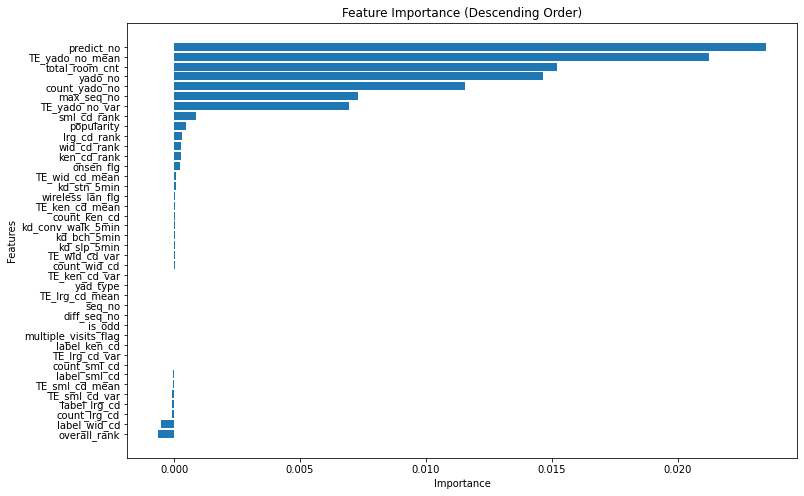

In [7]:
import matplotlib.pyplot as plt

# トレーニングデータセットでのPoolを作成（もしまだ作成していない場合）
#train_pool = Pool(data=train_data[features], label=train_data[target], group_id=train_data[query_ids])

# 特徴量の重要度を取得（トレーニングデータセットを使用）
feature_importances = model.get_feature_importance(train_pool, prettified=True)

# 特徴量の重要度を降順に並び替え
feature_importances.sort_values(by='Importances', ascending=False, inplace=True)

# 特徴量の重要度を表示
print(feature_importances)

# 特徴量の重要度をグラフで表示（降順）
plt.figure(figsize=(12, 8))
plt.barh(feature_importances['Feature Id'], feature_importances['Importances'])
plt.gca().invert_yaxis()  # y軸を逆順にして、重要度が高い特徴量を上に表示
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance (Descending Order)')
plt.show()



In [8]:
# train_dfのyado_noをyad_noに変更
train_df.rename(columns={'yado_no': 'yad_no'}, inplace=True)

In [9]:
train_df['oof_pred'] = oof_pred
train_df[['session_id', 'yad_no', 'oof_pred']].head()

,session_id,yad_no,oof_pred
0,000125c737df1802b6e365f93c96d3c8,7531,0.360529
1,000125c737df1802b6e365f93c96d3c8,441,0.154430
2,000125c737df1802b6e365f93c96d3c8,2480,0.262954
3,000125c737df1802b6e365f93c96d3c8,13240,0.148458
4,000125c737df1802b6e365f93c96d3c8,10378,0.217223


In [10]:
train_df[['session_id', 'yad_no', 'oof_pred']]

,session_id,yad_no,oof_pred
0,000125c737df1802b6e365f93c96d3c8,7531,0.360529
1,000125c737df1802b6e365f93c96d3c8,441,0.154430
2,000125c737df1802b6e365f93c96d3c8,2480,0.262954
3,000125c737df1802b6e365f93c96d3c8,13240,0.148458
4,000125c737df1802b6e365f93c96d3c8,10378,0.217223
...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,-2.924402
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,-2.507272
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,-1.716543
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,-3.397919


In [11]:
oof_pred_df = train_df[['session_id', 'yad_no', 'oof_pred']]
oof_pred_df

,session_id,yad_no,oof_pred
0,000125c737df1802b6e365f93c96d3c8,7531,0.360529
1,000125c737df1802b6e365f93c96d3c8,441,0.154430
2,000125c737df1802b6e365f93c96d3c8,2480,0.262954
3,000125c737df1802b6e365f93c96d3c8,13240,0.148458
4,000125c737df1802b6e365f93c96d3c8,10378,0.217223
...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,-2.924402
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,-2.507272
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,-1.716543
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,-3.397919


In [12]:
# アンサンブル用にoof_predを保存
oof_pred_df.to_csv('../ensemble/catRanker_ver10_oof_pred.csv', index=False)

In [13]:
oof_pred_df

,session_id,yad_no,oof_pred
0,000125c737df1802b6e365f93c96d3c8,7531,0.360529
1,000125c737df1802b6e365f93c96d3c8,441,0.154430
2,000125c737df1802b6e365f93c96d3c8,2480,0.262954
3,000125c737df1802b6e365f93c96d3c8,13240,0.148458
4,000125c737df1802b6e365f93c96d3c8,10378,0.217223
...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,-2.924402
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,-2.507272
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,-1.716543
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,-3.397919


### CVの計算

In [14]:
train_log_df = pd.read_csv('../train_log.csv')
train_label_df = pd.read_csv('../train_label.csv')

In [15]:
import pandas as pd

# oof_pred_dfを事前に処理しておきます。
# ここで'session_id'にインデックスを設定し、'oof_pred'でソートします。
# これにより、フィルタリングとソートのコストを削減できます。
oof_pred_df = oof_pred_df.sort_values(['session_id', 'oof_pred'], ascending=[True, False])
oof_pred_df.set_index('session_id', inplace=True)

In [16]:
%%time
def get_top_recommendations(session_id, df):
    """
    この関数は指定されたsession IDに基づいて、推薦確率に基づいた宿泊施設のリストを返します。

    パラメータ:
    session_id (str): 推薦をフィルタリングするためのセッションID。
    df (pd.DataFrame): 推薦が含まれているDataFrame。

    戻り値:
    list: 推薦確率に基づいてソートされた宿泊施設ID(`yad_no`)のリスト。
    """
    try:
        # インデックスを使ってデータを取得
        recommendations = df.loc[session_id, 'yad_no']
        # Seriesオブジェクトの値をリストに変換
        return recommendations.values.tolist()
    except KeyError:
        # 指定されたsession_idが存在しない場合は空のリストを返す
        return []


# 使用例:
session_id_to_check = '000104bdffaaad1a1e0a9ebacf585f33'
recommendations = get_top_recommendations(session_id_to_check, oof_pred_df)
print(recommendations)

[3894, 7749, 902, 11380, 1284, 5490, 254, 12491, 4072]
CPU times: user 155 ms, sys: 3.97 ms, total: 159 ms
Wall time: 159 ms


In [17]:
# セッションIDごとに yad_no のリストを作成
session_yadno_map = train_log_df.groupby('session_id')['yad_no'].apply(list).to_dict() #ここをtrain, testで変える  train_log_df, test_log_df


def generate_recommendation(i):
    
    # 推薦する宿を格納するリスト
    pred_recommendations = []
    
    # 指定セッションの宿を抽出
    session_id = train_label_df.loc[i, 'session_id']  #ここをtrain, testで変える  train_label_df, test_session_df
    yado_no = session_yadno_map.get(session_id, [])
    last_yado = yado_no[-1] if yado_no else None
    yado_no = pd.Series(yado_no).drop_duplicates().tolist()
    
    pred_recommendations.extend(yado_no) # 最後に訪問された宿を除外
    if last_yado in pred_recommendations:
        pred_recommendations.remove(last_yado)
    
    # 各セッションのcandidateを並べ替えたもの
    sorted_covisitation = get_top_recommendations(session_id=session_id, df=oof_pred_df)
    pred_recommendations.extend(sorted_covisitation)

    return i, pred_recommendations[:10]


# マルチプロセス処理の実行
results = []
with ProcessPoolExecutor(max_workers=16) as executor: # ここのmax_workersは手持ちのCPUのスレッド数によって適宜変える
    future_to_session = {executor.submit(generate_recommendation, i): i for i in range(len(train_label_df))}
    for future in tqdm(as_completed(future_to_session), total=len(train_label_df), desc="Processing recommendations"):
        index = future_to_session[future]
        result = future.result()
        results.append((index, result))

results.sort(key=lambda x: x[0])
preds = [result for i, result in results]

Processing recommendations: 100%|██████████| 288698/288698 [00:43<00:00, 6603.35it/s]


In [18]:
submission_df = pd.DataFrame(preds)
submission_df
submission_df[1]

# 推薦リストを新しい列に展開する
result_df = submission_df[1].apply(pd.Series)
# 新しい列名を設定する
result_df.columns = [f'predict_{i}' for i in range(result_df.shape[1])]
# 最初の列にセッションIDを追加する
# result_df.insert(0, 'session_id', submission_df.index)
# 展開されたDataFrameを表示
result_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,2808,4101,5289,997,12846,3324,11882,9208,9207,9209
1,8253,1586,2570,4488,8747,2259,11104,3725,8225,3564
2,4863,5238,13642,9039,1967,2957,6722,4355,11724,7509
3,626,755,13296,109,11715,7812,13549,1341,7872,2272
4,96,3894,7749,902,11380,1284,5490,254,12491,4072
...,...,...,...,...,...,...,...,...,...,...
288693,5719,13210,10522,13079,3725,10955,13717,1586,8677,2876
288694,513,4767,2900,963,5299,399,8465,6654,8703,3940
288695,3566,7820,10364,9558,2087,4398,4040,12240,844,7308
288696,10619,12500,570,11091,7551,3238,10616,12781,12829,11316


### 要素の集合にバグがないかを確認

In [19]:
candidate_ver15_train = pd.read_csv('../data/candidate_ver15_train.csv')

In [20]:
# 既存のDataFrameを読み込む
df1 = candidate_ver15_train
df2 = result_df#.drop(columns=['has_duplicates'])
# 各行を集合として保存するリストを初期化
sets_in_df1 = [set(row) for index, row in df1.iterrows()]
sets_in_df2 = [set(row) for index, row in df2.iterrows()]

# 互いに異なる行の件数をカウントする
unique_count = sum(1 for set1, set2 in zip(sets_in_df1, sets_in_df2) if set1 != set2)

# 結果を出力
print(unique_count)


0


### 順位変動のあったカラムを確認する

In [21]:
candidate_ver15_train

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,11882,2808,5289,4101,3324,12846,997,9207,9209,9208
1,8253,8747,2570,1586,11104,3725,4488,2259,3564,8225
2,9039,6722,7509,4355,4863,11724,5238,13642,1967,2957
3,626,755,11715,7812,109,2272,13296,1341,13549,7872
4,96,3894,7749,902,11380,5490,1284,12491,254,4072
...,...,...,...,...,...,...,...,...,...,...
288693,13210,13079,2876,3725,8677,13717,1586,10955,10522,5719
288694,8703,3940,399,4767,2900,6654,5299,8465,963,513
288695,7308,12240,4040,7820,4398,2087,9558,3566,844,10364
288696,10619,570,12500,11091,7551,3238,10616,12781,12829,11316


In [22]:
# 各要素が一致しているかどうかをチェック
diff = candidate_ver15_train != result_df

# 一致していない行のインデックスを抽出
mismatched_indices = diff.any(axis=1)
mismatched_rows = candidate_ver15_train[mismatched_indices]

print("一致していない行のインデックス：")
print(mismatched_indices)
print("一致していない行：")
print(len(mismatched_rows))

一致していない行のインデックス：
0         True
1         True
2         True
3         True
4         True
          ... 
288693    True
288694    True
288695    True
288696    True
288697    True
Length: 288698, dtype: bool
一致していない行：
287231


In [23]:
candidate_ver15_train[mismatched_indices].head(20)

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,11882,2808,5289,4101,3324,12846,997,9207,9209,9208
1,8253,8747,2570,1586,11104,3725,4488,2259,3564,8225
2,9039,6722,7509,4355,4863,11724,5238,13642,1967,2957
3,626,755,11715,7812,109,2272,13296,1341,13549,7872
4,96,3894,7749,902,11380,5490,1284,12491,254,4072
5,10510,4823,12544,5369,1,9207,9199,9200,9201,9202
6,7531,441,2480,13240,10378,2282,7273,10442,12774,4574
7,4744,9508,7681,10362,12962,1755,12125,12464,111,10544
8,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
9,10478,379,550,3278,3483,6592,9773,9430,4303,2806


In [24]:
result_df[mismatched_indices].head(20)

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,2808,4101,5289,997,12846,3324,11882,9208,9207,9209
1,8253,1586,2570,4488,8747,2259,11104,3725,8225,3564
2,4863,5238,13642,9039,1967,2957,6722,4355,11724,7509
3,626,755,13296,109,11715,7812,13549,1341,7872,2272
4,96,3894,7749,902,11380,1284,5490,254,12491,4072
5,12544,4823,10510,5369,9207,9199,9201,9200,9202,1
6,4574,10442,7531,2480,10378,441,13240,12774,7273,2282
7,10362,111,12125,12464,10544,4744,12962,9508,7681,1755
8,12432,13220,3802,3644,2164,9723,1227,4014,899,13702
9,10478,6592,550,379,9430,3483,3278,4303,2806,9773


In [25]:
y_true = train_label['yad_no'].values.reshape(-1, 1)
y_pred = result_df.values

In [26]:
# Recall(候補にあげたものが)のy_trueに含まれているものの割合

# マッチするかどうかをチェックするリストを初期化
matches = []

# y_pred の各サブアレイと y_true の値を比較
for pred, true in zip(y_pred, y_true):
    # pred はサブアレイ、true は値
    matches.append(int(true in pred))

# matches は、指定された条件に基づいて 0 と 1 のリストです
print(matches)

# matches は先のステップで生成した 0 と 1 のリストです。
# 1 の割合を計算
one_ratio = sum(matches) / len(matches)

# 割合をプリント
print("Recall is: {:.2%}".format(one_ratio))

[1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 

In [27]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the AP at k between two lists of items.
    """
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean AP at k between two lists of list of items.
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

# y_true と y_pred をリストに変換
y_true_list = [list(x) for x in y_true]
y_pred_list = [list(x) for x in y_pred]

# MAP@10 を計算
map_at_10 = mapk(y_true_list, y_pred_list, k=10)
print(f'Map@10  {map_at_10}')

Map@10  0.48390176937794155


In [28]:
# 各行内で重複があるかどうかをチェック
def check_row_duplicates(row):
    # setを用いてユニークな要素のみを抽出し、その長さが元の行の長さと等しいかを比較
    return len(row) != len(set(row))
# check_row_duplicates関数を各行に適用し、結果を新しい列に格納
result_df['has_duplicates'] = result_df.apply(check_row_duplicates, axis=1)
# 重複がある行のみをフィルタリング
rows_with_duplicates = result_df[result_df['has_duplicates']]
# 結果を表示
print(len(rows_with_duplicates))

0


In [29]:
# 欠損がないかをチェック
result_df.isnull().sum(axis=1).sum()

0

In [30]:
result_df.head()

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9,has_duplicates
0,2808,4101,5289,997,12846,3324,11882,9208,9207,9209,False
1,8253,1586,2570,4488,8747,2259,11104,3725,8225,3564,False
2,4863,5238,13642,9039,1967,2957,6722,4355,11724,7509,False
3,626,755,13296,109,11715,7812,13549,1341,7872,2272,False
4,96,3894,7749,902,11380,1284,5490,254,12491,4072,False


### 推論用の候補テーブルを作成する

In [31]:
test_log_df = pd.read_csv('../test_log.csv')
test_session_df = pd.read_csv('../test_session.csv')

In [32]:
print(np.mean(test_pred, axis=0))  # 各foldのテストデータの予測値の平均をとる
print(len(np.mean(test_pred, axis=0)))

[ 1.0295379   0.07825355  0.42711947 ... -0.02021462  0.12036638
  0.23275435]
1683604


In [33]:
# test_predの形を調べる
print(np.array(test_pred).shape)

(10, 1683604)


In [34]:
# test_dfのyado_noをyad_noに変更
test_df.rename(columns={'yado_no': 'yad_no'}, inplace=True)

In [35]:
test_df['target'] = np.mean(test_pred, axis=0)
test_df[['session_id', 'yad_no', 'target']].head()

,session_id,yad_no,target
0,00001149e9c73985425197104712478c,11561,1.029538
1,00001149e9c73985425197104712478c,4714,0.078254
2,00001149e9c73985425197104712478c,2680,0.427119
3,00001149e9c73985425197104712478c,4420,-0.693447
4,00001149e9c73985425197104712478c,5466,-0.458624


In [36]:
test_oof_pred_df = test_df[['session_id', 'yad_no', 'target']]
test_oof_pred_df

,session_id,yad_no,target
0,00001149e9c73985425197104712478c,11561,1.029538
1,00001149e9c73985425197104712478c,4714,0.078254
2,00001149e9c73985425197104712478c,2680,0.427119
3,00001149e9c73985425197104712478c,4420,-0.693447
4,00001149e9c73985425197104712478c,5466,-0.458624
...,...,...,...
1683599,ffffe984aafd6127ce8e43e3ca40c79d,5623,0.100099
1683600,ffffe984aafd6127ce8e43e3ca40c79d,3781,0.162271
1683601,ffffe984aafd6127ce8e43e3ca40c79d,11994,-0.020215
1683602,ffffe984aafd6127ce8e43e3ca40c79d,634,0.120366


In [37]:
# test_oof_pred_dfのカラム名を変更
test_oof_pred_df.rename(columns={'target': 'oof_pred'}, inplace=True)
test_oof_pred_df

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,session_id,yad_no,oof_pred
0,00001149e9c73985425197104712478c,11561,1.029538
1,00001149e9c73985425197104712478c,4714,0.078254
2,00001149e9c73985425197104712478c,2680,0.427119
3,00001149e9c73985425197104712478c,4420,-0.693447
4,00001149e9c73985425197104712478c,5466,-0.458624
...,...,...,...
1683599,ffffe984aafd6127ce8e43e3ca40c79d,5623,0.100099
1683600,ffffe984aafd6127ce8e43e3ca40c79d,3781,0.162271
1683601,ffffe984aafd6127ce8e43e3ca40c79d,11994,-0.020215
1683602,ffffe984aafd6127ce8e43e3ca40c79d,634,0.120366


In [38]:
test_oof_pred_df

,session_id,yad_no,oof_pred
0,00001149e9c73985425197104712478c,11561,1.029538
1,00001149e9c73985425197104712478c,4714,0.078254
2,00001149e9c73985425197104712478c,2680,0.427119
3,00001149e9c73985425197104712478c,4420,-0.693447
4,00001149e9c73985425197104712478c,5466,-0.458624
...,...,...,...
1683599,ffffe984aafd6127ce8e43e3ca40c79d,5623,0.100099
1683600,ffffe984aafd6127ce8e43e3ca40c79d,3781,0.162271
1683601,ffffe984aafd6127ce8e43e3ca40c79d,11994,-0.020215
1683602,ffffe984aafd6127ce8e43e3ca40c79d,634,0.120366


In [39]:
# アンサンブル用にoof_predを保存
test_oof_pred_df.to_csv('../ensemble/catRanker_ver10_test_pred.csv', index=False)

In [40]:
import pandas as pd

# oof_pred_dfを事前に処理しておきます。
# ここで'session_id'にインデックスを設定し、'oof_pred'でソートします。
# これにより、フィルタリングとソートのコストを削減できます。
test_oof_pred_df = test_oof_pred_df.sort_values(['session_id', 'oof_pred'], ascending=[True, False])
test_oof_pred_df.set_index('session_id', inplace=True)

In [41]:
%%time
def get_top_recommendations(session_id, df):
    """
    この関数は指定されたsession IDに基づいて、推薦確率に基づいた宿泊施設のリストを返します。

    パラメータ:
    session_id (str): 推薦をフィルタリングするためのセッションID。
    df (pd.DataFrame): 推薦が含まれているDataFrame。

    戻り値:
    list: 推薦確率に基づいてソートされた宿泊施設ID(`yad_no`)のリスト。
    """
    try:
        # インデックスを使ってデータを取得
        recommendations = df.loc[session_id, 'yad_no']
        # Seriesオブジェクトの値をリストに変換
        return recommendations.values.tolist()
    except KeyError:
        # 指定されたsession_idが存在しない場合は空のリストを返す
        return []


# 使用例:
session_id_to_check = 'ffffe984aafd6127ce8e43e3ca40c79d'
recommendations = get_top_recommendations(session_id_to_check, test_oof_pred_df)
print(recommendations)

[1891, 11723, 12767, 12620, 3781, 634, 5623, 10729, 867, 11994]
CPU times: user 96 ms, sys: 11 µs, total: 96 ms
Wall time: 96 ms


In [42]:
# セッションIDごとに yad_no のリストを作成
session_yadno_map = test_log_df.groupby('session_id')['yad_no'].apply(list).to_dict() #ここをtrain, testで変える  train_log_df, test_log_df


def generate_recommendation(i):
    
    # 推薦する宿を格納するリスト
    pred_recommendations = []
    
    # 指定セッションの宿を抽出
    session_id = test_session_df.loc[i, 'session_id']  #ここをtrain, testで変える  train_label_df, test_session_df
    yado_no = session_yadno_map.get(session_id, [])
    last_yado = yado_no[-1] if yado_no else None
    yado_no = pd.Series(yado_no).drop_duplicates().tolist()
    
    pred_recommendations.extend(yado_no) # 最後に訪問された宿を除外
    if last_yado in pred_recommendations:
        pred_recommendations.remove(last_yado)
    
    # 各セッションのcandidateを並べ替えたもの
    sorted_covisitation = get_top_recommendations(session_id=session_id, df=test_oof_pred_df)
    pred_recommendations.extend(sorted_covisitation)

    return i, pred_recommendations[:10]


# マルチプロセス処理の実行
results = []
with ProcessPoolExecutor(max_workers=16) as executor: # ここのmax_workersは手持ちのCPUのスレッド数によって適宜変える
    future_to_session = {executor.submit(generate_recommendation, i): i for i in range(len(test_session_df))}
    for future in tqdm(as_completed(future_to_session), total=len(test_session_df), desc="Processing recommendations"):
        index = future_to_session[future]
        result = future.result()
        results.append((index, result))

results.sort(key=lambda x: x[0])
preds = [result for i, result in results]

Processing recommendations: 100%|██████████| 174700/174700 [00:25<00:00, 6739.87it/s]


In [43]:
submission_df = pd.DataFrame(preds)
submission_df
submission_df[1]

# 推薦リストを新しい列に展開する
test_expanded_df = submission_df[1].apply(pd.Series)
# 新しい列名を設定する
test_expanded_df.columns = [f'predict_{i}' for i in range(test_expanded_df.shape[1])]
# 最初の列にセッションIDを追加する
# expanded_df.insert(0, 'session_id', submission_df.index)
# 展開されたDataFrameを表示
test_expanded_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,11561,2680,4714,5466,9830,4420,9534,5785,6563
1,143,7014,613,8108,11923,6555,4066,6129,11237,12862
2,757,9190,7710,9910,1774,10485,6721,410,13570,6730
3,12341,3359,6991,1542,13521,5080,10861,4180,6489,10746
4,10826,9020,3476,2862,9623,3854,12029,5372,3844,6161
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,7062,2278,10997,10042,3440,9743
174696,13702,4014,1227,3802,13220,12432,899,9723,2164,3644
174697,13241,13719,12939,2087,5810,7308,13797,11037,11796,8143
174698,3100,10287,13672,2373,3002,2692,5513,1687,4976,12281


In [44]:
# 各行内で重複があるかどうかをチェック

def check_row_duplicates(row):
    # setを用いてユニークな要素のみを抽出し、その長さが元の行の長さと等しいかを比較
    return len(row) != len(set(row))
# check_row_duplicates関数を各行に適用し、結果を新しい列に格納
test_expanded_df['has_duplicates'] = test_expanded_df.apply(check_row_duplicates, axis=1)
# 重複がある行のみをフィルタリング
rows_with_duplicates = test_expanded_df[test_expanded_df['has_duplicates']]
# 結果を表示
print(len(rows_with_duplicates))

0


In [45]:
# 欠損がないかをチェック
test_expanded_df.isnull().sum(axis=1).sum()

0

In [46]:
candidate_ver15_test = pd.read_csv('../data/candidate_ver15_test.csv')
candidate_ver15_test

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,11561,4714,2680,4420,5466,9830,9534,6563,5785
1,143,4066,6555,7014,11923,8108,6129,613,11237,12862
2,757,9190,7710,1774,9910,10485,6721,410,13570,6730
3,12341,3359,6991,1542,13521,5080,10861,4180,10746,6489
4,9020,2862,10826,12029,3854,3476,9623,3844,5372,6161
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,10997,7062,9743,2278,10042,3440
174696,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
174697,13241,13797,13719,12939,7308,2087,8143,11796,11037,5810
174698,3100,10287,3002,2373,12281,4976,13672,2692,5513,1687


In [47]:
# 行ごとに要素の集合が異なっていないかをチェック
import pandas as pd

# 既存のDataFrameを読み込む
df1 = candidate_ver15_test
df2 = test_expanded_df.drop('has_duplicates', axis=1)
# 各行を集合として保存するリストを初期化
sets_in_df1 = [set(row) for index, row in df1.iterrows()]
sets_in_df2 = [set(row) for index, row in df2.iterrows()]

# 互いに異なる行の件数をカウントする
unique_count = sum(1 for set1, set2 in zip(sets_in_df1, sets_in_df2) if set1 != set2)

# 結果を出力
print(unique_count)

0


In [48]:
candidate_ver15_test

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,11561,4714,2680,4420,5466,9830,9534,6563,5785
1,143,4066,6555,7014,11923,8108,6129,613,11237,12862
2,757,9190,7710,1774,9910,10485,6721,410,13570,6730
3,12341,3359,6991,1542,13521,5080,10861,4180,10746,6489
4,9020,2862,10826,12029,3854,3476,9623,3844,5372,6161
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,10997,7062,9743,2278,10042,3440
174696,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
174697,13241,13797,13719,12939,7308,2087,8143,11796,11037,5810
174698,3100,10287,3002,2373,12281,4976,13672,2692,5513,1687


In [49]:
test_expanded_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9,has_duplicates
0,3560,11561,2680,4714,5466,9830,4420,9534,5785,6563,False
1,143,7014,613,8108,11923,6555,4066,6129,11237,12862,False
2,757,9190,7710,9910,1774,10485,6721,410,13570,6730,False
3,12341,3359,6991,1542,13521,5080,10861,4180,6489,10746,False
4,10826,9020,3476,2862,9623,3854,12029,5372,3844,6161,False
...,...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,7062,2278,10997,10042,3440,9743,False
174696,13702,4014,1227,3802,13220,12432,899,9723,2164,3644,False
174697,13241,13719,12939,2087,5810,7308,13797,11037,11796,8143,False
174698,3100,10287,13672,2373,3002,2692,5513,1687,4976,12281,False


In [50]:
test_expanded_df.drop(columns=['has_duplicates']).to_csv('../submissions/catRanker_ver10.csv', index=False)